# Producing the DTMF tones in software

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

def requantize(signal, old_resolution: int, new_resolution: int):
    return np.round(signal / (old_resolution - new_resolution), decimals=0).astype(int)

The basic idea is to start out with a $LUT$ (a simple array) that samples a simple sine wave, $\sin(x)$, at a rate of say $N$ times per period.

In [33]:
N = 128

# the values computed have to be converted into integers scaled to account for the 10-bit DAC.
DAC_RESOLUTION=8

def generate_lut(resolution: int, N: int):
    # sample the sin function at a rate of N.
    sin_samples = [np.sin(i * 2 * np.pi / N) for i in range(0, N)]
    return np.array([(x + 1) * ((1 << resolution) - 1) // 2 for x in sin_samples])

lut = generate_lut(DAC_RESOLUTION, N)

Now we are interested in computing the sum of two sine waves of frequency $f_1$ and $f_2$ sampled at a certain fixed sampling rate.

Without loss of generality assume that $f_1 \ge f_2$. Let us fix the sampling frequency at

$$ f_s = nf_1 $$

where $n$ is a divisor of $N$. Since the DTMF tone signal is bandlimited to $f_1$, we can assume that $n \ge 2$ and that $n$ has to be made as small as possible without reducing the quality of the output tone.

The relationship between time $t$ and the sample number $i$ is then

$$ t = \frac{i}{f_s} = \frac{i}{nf_1} $$

so that the value of the sine wave of frequency $f_1$ at sample number $i$ is simply given by:

$$ \sin(2\pi f_1 t) = \sin\bigg(\frac{2\pi i}{n}\bigg) = \sin\bigg(\frac{2\pi i}{n}\times \frac{N}{N}\bigg) = LUT\bigg[\frac{Ni}{n} \bmod N\bigg] $$

Unlike with $\sin(2\pi f_1t)$, the required value for $\sin(2\pi f_2t)$ may not be in the lookup table. However, we can find two indexes which the required sine value "falls in between" and average them:
$$ \frac{1}{2}\Bigg(LUT\bigg[\bigg\lfloor\frac{f_2}{f_1}\frac{N}{n}i\bigg\rfloor \bmod N\bigg] + LUT\bigg[\bigg\lceil\frac{f_2}{f_1}\frac{N}{n}i\bigg\rceil \bmod N\bigg]\Bigg) $$

Note that this formula works even when the required value happens to be in the lookup table (this happens if $f_2Ni$ divides $f_1n$). In this case
$$ \bigg\lceil\frac{f_2}{f_1}\frac{N}{n}i\bigg\rceil = \bigg\lfloor\frac{f_2}{f_1}\frac{N}{n}i\bigg\rfloor \in \mathbb{N} $$
and hence we get the exact sample from the LUT.

The ceiling of the integer division can be computed efficiently using the identity:
$$ \bigg\lfloor \frac{n}{m} \bigg\rfloor = - \bigg\lceil -\frac{n}{m} \bigg\rceil $$

If $N$ is chosen to be a power of 2, the remainders above can be computed using bitmasks via the formula
$$ x \bmod N = x \,\,\&\,\,(N - 1) $$

In [34]:
def tone(f1: int, f2: int, samplenum: int, n: int = 32) -> int:
    """
    Compute an approximate value for the tone at samplenum
    """
    return (
        lut[((samplenum * N) // n) % N] 
        + (lut[(f2 * samplenum * N // (f1 * n)) % N] + lut[-(-f2 * samplenum * N // (f1 * n)) % N]) // 2
    )

To test feasability of this approach, we will compare the approximate tone produced for $1209$ and $697\,\,Hz$ with the exact tone.

In [35]:
# Compute approximate tone data
# in this case the tone is the combination of 1209 and 697 kHz frequencies (representing an input symbol of 1).
f1, f2 = 1209, 697
n = 4

approx_tone = np.array([tone(f1, f2, i, n) for i in range(0, 10000)])

In [36]:
# array of timesteps for our audio signal.
# Since sampling frequency is determined by the highest frequency, \
#   and we have N samples over a single sine wave period,
#   a time step is k/(1209*N)s
t = np.array([i/(f1*n) for i in range(0,10000)])

# This is the exact tone that should be produced.
def exact_tone(t):
    return ((np.sin(2*np.pi*f1*t)+np.sin(2*np.pi*f2*t))+2) * ((1 << DAC_RESOLUTION) - 1) / 2

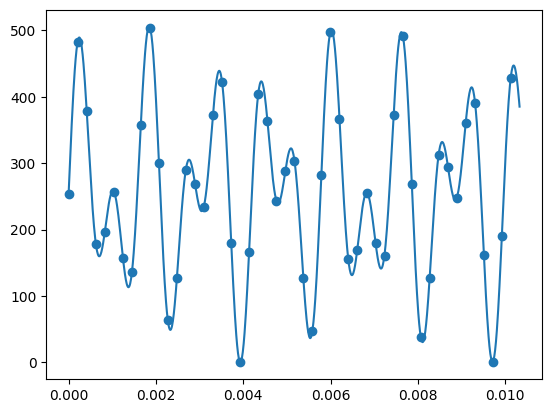

In [37]:
PLOT_START, PLOT_END = 0, 50

plt.scatter(t[PLOT_START:PLOT_END], approx_tone[PLOT_START:PLOT_END])
plot_t = np.arange(PLOT_START/(f1*n), PLOT_END/(f1*n), 1e-5)
plt.plot(plot_t, exact_tone(plot_t));


In [38]:
# Show audio widget for listening to approximate tone produced by our C program.
fs= f1*n
ipd.display(ipd.Audio(data=approx_tone, rate=fs))

In [39]:
# Show audio widget for listening to exact tone.
ipd.display(ipd.Audio(data=exact_tone(t), rate=fs))